In [53]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [54]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [55]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect,func

In [56]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [57]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [58]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [59]:
# Save references to each table
measurement = dbm.classes.measurement
station = dbm.classes.station

In [60]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [61]:
# Find the most recent date in the data set.
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
results_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
results=session.query(measurement.date, measurement.prcp).order_by(measurement.date.asc()).\
        filter(measurement.date>=year_back).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})
# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)

In [63]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [64]:
# Design a query to calculate the total number of stations in the dataset
station_count_total=session.query(func.count(station.id)).all()
station_count_total

[(9,)]

In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_measurment_join=session.query(measurement.station,func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(func.count(measurement.station).desc()).all()
station_measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [66]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results_temp=session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
             filter(measurement.station==station_measurment_join[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

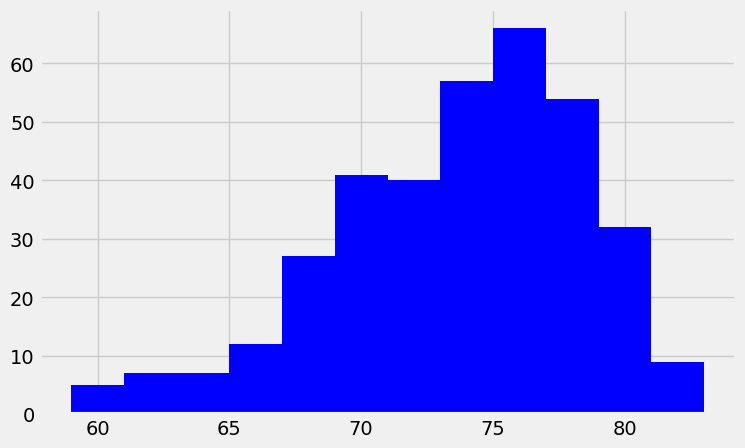

In [67]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results_date=session.query(measurement.date).order_by(measurement.date.desc()).\
             filter(measurement.station==station_measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(measurement.tobs).\
             filter(measurement.station==station_measurment_join[0][0]).\
             filter(measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)

hist = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)


plt.show()

# Close Session

In [68]:
# Close Session
session.close()